In [1]:
%load_ext autoreload
%autoreload 2
import time
import multiprocessing
import os
from pathlib import Path
import shutil
import numpy as np
import thor.data as data
import thor.data.dispatch as dispatch
import thor.grid as grid
import thor.option as option
import thor.track as track
import thor.analyze as analyze
import thor.parallel as parallel
import thor.visualize as visualize

notebook_name = "gridrad_demo.ipynb"


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Parent directory for saving outputs
base_local = Path.home() / "THOR_output"
start = "2010-01-20T18:00:00"
end = "2010-01-21T03:30:00"
event_start = "2010-01-20"

period = parallel.get_period(start, end)
intervals = parallel.get_time_intervals(start, end, period=period)

output_parent = base_local / "runs/gridrad_demo"
if output_parent.exists():
    shutil.rmtree(output_parent)
options_directory = output_parent / "options"

# Create the data_options dictionary
converted_options = {"save": True, "load": False, "parent_converted": None}
gridrad_options = data.gridrad.gridrad_data_options(
    start=start, end=end, converted_options=converted_options, event_start=event_start
)
lon_range = [-102, -89]
lat_range = [27, 39]
era5_pl_options = data.era5.data_options(
    start=start, end=end, longitude_range=lon_range, latitude_range=lat_range
)
args_dict = {"start": start, "end": end, "data_format": "single-levels"}
args_dict.update({"longitude_range": lon_range, "latitude_range": lat_range})
era5_sl_options = data.era5.data_options(**args_dict)

data_options = option.consolidate_options(
    [gridrad_options, era5_pl_options, era5_sl_options]
)

dispatch.check_data_options(data_options)
data.option.save_data_options(data_options, options_directory=options_directory)
gridrad_options = data_options["gridrad"]

# Create the grid_options dictionary using the first file in the cpol dataset
grid_options = grid.create_options(
    name="geographic", regrid=False, altitude_spacing=None, geographic_spacing=None
)
grid.check_options(grid_options)
grid.save_grid_options(grid_options, options_directory=options_directory)

# Create the track_options dictionary
track_options = option.default_track_options(dataset="gridrad")
# Modify the default options for gridrad. Because grids so large we now use a distinct
# global flow box for each object.
track_options.levels[1].objects[0].tracking.global_flow_margin = 70
track_options.levels[1].objects[0].tracking.unique_global_flow = False
track_options.to_yaml(options_directory / "track.yml")

# Create the display_options dictionary
visualize_options = {
    obj: visualize.option.runtime_options(obj, save=True, style="presentation")
    for obj in ["mcs"]
}
visualize_options = None

2024-10-18 21:54:52,323 - thor.utils - DEBUG - Saving options to /home/ewan/THOR_output/runs/gridrad_demo/options/data.yml


2024-10-18 21:54:52,348 - thor.grid - WARNING - Shape not specified. Will attempt to infer from input.
2024-10-18 21:54:52,349 - thor.utils - DEBUG - Saving options to /home/ewan/THOR_output/runs/gridrad_demo/options/grid.yml


In [3]:
times = data.utils.generate_times(data_options["gridrad"])
tracks = track.simultaneous_track(
    times,
    data_options,
    grid_options,
    track_options,
    visualize_options,
    output_directory=output_parent
)

2024-10-18 21:54:54,543 - thor.track - INFO - Beginning thor run. Saving output to /home/ewan/THOR_output/runs/gridrad_demo.
2024-10-18 21:54:54,545 - thor.track - INFO - Beginning simultaneous tracking.


2024-10-18 21:54:54,652 - thor.track - INFO - Processing 2010-01-20T18:00:00.
2024-10-18 21:54:54,653 - thor.data.gridrad - INFO - Updating gridrad dataset for 2010-01-20T18:00:00.
2024-10-18 21:54:54,654 - thor.data.gridrad - INFO - Converting gridrad data from nexrad_3d_v4_2_20100120T180000Z.nc
2024-10-18 21:54:54,655 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:00:00.000000000.
2024-10-18 21:54:54,848 - thor.data.gridrad - DEBUG - Filtering GridRad data
2024-10-18 21:54:55,628 - thor.data.gridrad - DEBUG - Removing clutter from the GridRad data
2024-10-18 21:54:55,675 - thor.data.gridrad - DEBUG - Removing speckles from the GridRad data
2024-10-18 21:54:55,937 - thor.data.gridrad - DEBUG - Removing low level clutter from the GridRad data
2024-10-18 21:54:56,202 - thor.data.gridrad - DEBUG - Removing speckles from the GridRad data
2024-10-18 21:54:56,528 - thor.data.gridrad - DEBUG - Got domain mask for gridrad.
2024-10-18 21:54:56,848 - thor.data.gr

In [16]:
num_processes = int(.75*os.cpu_count())

with multiprocessing.get_context("spawn").Pool(initializer=parallel.initialize_process) as pool:
    results = []
    for i, time_interval in enumerate(intervals):
        time.sleep(1)
        args = [i, time_interval, data_options.copy(), grid_options.copy()]
        args += [track_options.model_copy(deep=True), visualize_options] 
        args += [output_parent, "gridrad"]
        args = tuple(args)
        results.append(pool.apply_async(parallel.track_interval, args))
    pool.close()
    pool.join()
    parallel.check_results(results)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

KeyboardInterrupt: 

In [4]:
parallel.stitch_run(output_parent, intervals, cleanup=True)

2024-10-18 13:56:10,369 - thor.parallel - INFO - Stitching all attribute, mask and record files.
2024-10-18 13:56:18,064 - thor.parallel - INFO - Stitching record files.
2024-10-18 13:56:18,112 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridrad_demo/records/filepaths/gridrad.csv
2024-10-18 13:56:18,117 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/gridrad_demo/records/filepaths/gridrad.yml
2024-10-18 13:56:18,121 - thor.parallel - INFO - Stitching attribute files.
2024-10-18 13:56:18,293 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridrad_demo/attributes/mcs/anvil/core.csv
2024-10-18 13:56:18,297 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/gridrad_demo/attributes/mcs/anvil/core.yml
2024-10-18 13:56:18,423 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridra

In [4]:
analysis_options = analyze.mcs.analysis_options()
analyze.mcs.process_velocities(output_parent)
analyze.mcs.quality_control(output_parent, analysis_options)
analyze.mcs.classify_all(output_parent)

2024-10-18 22:32:24,660 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridrad_demo/analysis/velocities.csv
2024-10-18 22:32:24,671 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/gridrad_demo/analysis/velocities.yml
2024-10-18 22:32:24,890 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridrad_demo/analysis/quality.csv
2024-10-18 22:32:24,894 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/gridrad_demo/analysis/quality.yml
2024-10-18 22:32:24,966 - thor.write.attribute - DEBUG - Writing attribute dataframe to /home/ewan/THOR_output/runs/gridrad_demo/analysis/classification.csv
2024-10-18 22:32:24,972 - thor.write.attribute - DEBUG - Saving attribute metadata to /home/ewan/THOR_output/runs/gridrad_demo/analysis/classification.yml


stratiform_offset inflow  \
time                universal_id                            
2010-01-20 18:00:00 1                      leading  right   
                    2                      leading  right   
2010-01-20 18:10:00 1                      leading  right   
                    2                      leading  right   
2010-01-20 18:20:00 1                      leading  right   
...                                            ...    ...   
2010-01-21 03:10:00 20                       right  front   
                    21                     leading  front   
                    23                    trailing  front   
2010-01-21 03:20:00 20                       right  front   
                    21                     leading  front   

                                 relative_stratiform_offset  \
time                universal_id                              
2010-01-20 18:00:00 1                                  left   
                    2                                  left   
2010-01-20 18:10:00 1                                  left   
                    2                                  left   
2010-01-20 18:20:00 1                                  left   
...                                                     ...   
2010-01-21 03:10:00 20                                right   
                    21                              leading   
                    23                             trailing   
2010-01-21 03:20:00 20                                right   
                    21                              leading   

                                                 tilt          propagation  
time                universal_id                                            
2010-01-20 18:00:00 1                      down-shear           down-shear  
                    2                      down-shear  shear-perpendicular  
2010-01-20 18:10:00 1                      down-shear           down-shear  
                    2             shear-perpendicular  shear-perpendicular  
2010-01-20 18:20:00 1             shear-perpendicular           down-shear  
...                                               ...                  ...  
2010-01-21 03:10:00 20            shear-perpendicular           down-shear  
                    21                     down-shear           down-shear  
                    23                       up-shear           down-shear  
2010-01-21 03:20:00 20            shear-perpendicular           down-shear  
                    21                     down-shear           down-shear  

[252 rows x 5 columns]

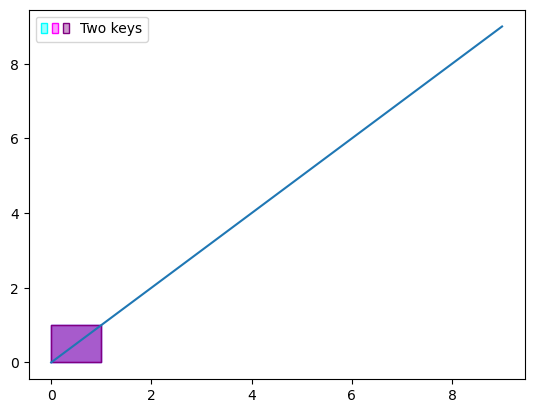

In [7]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.legend_handler import HandlerTuple


# Create custom legend artist using PatchCollection

colors = visualize.visualize.mask_colors
single_color = False
if single_color:
    colors = [colors[0]] * len(colors)
cmap = LinearSegmentedColormap.from_list("custom", colors, N=len(colors))

patches = []
for i in range(3):
    edge_color = mcolors.to_rgb(colors[i])
    fill_color = list(edge_color) + [0.4]  # Add alpha to fill color
    patch = mpatches.Rectangle(
        (0, 0), 1, 1, edgecolor=edge_color, facecolor=fill_color, label="test"
    )
    patches.append(patch)

fig, ax = plt.subplots()
ax.plot(range(10), label="Data")
collection = PatchCollection(patches, match_original=True, label="test")
# custom_legend = mpatches.Patch(edgecolor='none', facecolor='none', label='Objects')
ax.add_collection(collection)
# ax.legend(handles=[collection], loc="upper right")

l = ax.legend(
    [tuple(patches)],
    ["Two keys"],
    numpoints=1,
    handler_map={tuple: HandlerTuple(ndivide=None)},
)

plt.show()

In [14]:
figure_options = visualize.option.horizontal_attribute_options(
    "mcs_velocity_analysis", style="presentation", attributes=["velocity", "offset", "ambient"]
)
start_time = np.datetime64("2010-01-20T18:00")
end_time = np.datetime64(np.datetime64("2010-01-21T03:30"))
args = [output_parent, start_time, end_time, figure_options]
args_dict = {"parallel_figure": True, "dt": 5400, "by_date": False}
visualize.attribute.mcs_series(*args, **args_dict)

2024-10-19 09:18:48,890 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:00:00.000000000.
2024-10-19 09:18:49,055 - thor.data.gridrad - DEBUG - Filtering GridRad data
2024-10-19 09:18:49,652 - thor.data.gridrad - DEBUG - Removing clutter from the GridRad data
2024-10-19 09:18:49,702 - thor.data.gridrad - DEBUG - Removing speckles from the GridRad data
2024-10-19 09:18:49,951 - thor.data.gridrad - DEBUG - Removing low level clutter from the GridRad data
2024-10-19 09:18:50,195 - thor.data.gridrad - DEBUG - Removing speckles from the GridRad data
2024-10-19 09:18:50,518 - thor.data.gridrad - DEBUG - Got domain mask for gridrad.
2024-10-19 09:18:50,602 - thor.visualize.attribute - DEBUG - Getting grid from dataset at time 2010-01-20T18:00:00.000000000.
2024-10-19 09:18:50,604 - thor.data.gridrad - DEBUG - Got grid from dataset at time 2010-01-20T18:00:00.000000000.
2024-10-19 09:18:50,605 - thor.visualize.attribute - DEBUG - Rebuilding processed grid for time


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather 

2024-10-19 09:19:09,294 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:40:00.000000000.
2024-10-19 09:19:09,305 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:20:00.000000000.
2024-10-19 09:19:09,310 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:10:00.000000000.
2024-10-19 09:19:09,312 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:30:00.000000000.
2024-10-19 09:19:09,455 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T19:00:00.000000000.
2024-10-19 09:19:09,504 - thor.data.gridrad - DEBUG - Converting GridRad dataset at time 2010-01-20T18:50:00.000000000.
2024-10-19 09:19:09,801 - thor.data.gridrad - DEBUG - Filtering GridRad data
2024-10-19 09:19:09,865 - thor.data.gridrad - DEBUG - Filtering GridRad data
2024-10-19 09:19:09,871 - thor.data.gridrad - DEBUG - Filtering GridRad data
2024-10-19 09:19:09,900 - thor.data.gridrad - DEB